In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.signal import filtfilt
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras

from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Embedding


# Load Data

In [3]:
df_word=pd.read_csv("/content/drive/MyDrive/Programs/final_project/input/classes_V01.txt",sep="\t",header=None)

df_word.columns=['name','repetition','target','category']

df_word.head(2)

,name,repetition,target,category
0,"domestic cat, house cat, Felis domesticus, Fel...",24,n02121808,Mammals
1,"rock python, rock snake, Python sebae",29,n01744401,Reptile


In [4]:
#read complete merged file
df=pd.read_csv("/content/drive/MyDrive/Programs/final_project/output/merged.csv")
df.shape

(70060, 450)

In [5]:
df=df.iloc[:,1:]    #all data
#df=df.iloc[:100,1:]    #sample data (should be multiple of 5)
df.head(6)

,global_session_id,number_of_sessions,image_id,image_category,channels,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,...,t_405,t_406,t_407,t_408,t_409,t_410,t_411,t_412,t_413,t_414,t_415,t_416,t_417,t_418,t_419,t_420,t_421,t_422,t_423,t_424,t_425,t_426,t_427,t_428,t_429,t_430,t_431,t_432,t_433,t_434,t_435,t_436,t_437,t_438,t_439,t_440,t_441,t_442,t_443,t_444
0,2602,1,4823,n02077923,AF3,4320.000000,4332.307692,4334.871795,4342.564103,4333.333333,4313.333333,4318.974359,4349.743590,4358.974359,4335.384615,4321.025641,4333.333333,4345.641026,4334.358974,4321.025641,4320.000000,4321.538462,4320.000000,4311.794872,4309.230769,4311.282051,4301.025641,4288.205128,4291.794872,4296.923077,4290.769231,4303.076923,4337.435897,4334.358974,4298.974359,4292.307692,4305.128205,4305.641026,4305.641026,4303.589744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2602,1,4823,n02077923,AF4,4294.871795,4305.128205,4298.974359,4307.179487,4312.307692,4284.102564,4274.871795,4314.358974,4330.769231,4324.615385,4311.282051,4275.384615,4284.615385,4322.564103,4318.461538,4285.641026,4272.820513,4307.692308,4353.333333,4341.538462,4307.179487,4307.692308,4307.692308,4304.615385,4321.538462,4312.307692,4292.307692,4298.461538,4285.641026,4278.461538,4311.282051,4318.974359,4297.435897,4301.025641,4321.538462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2602,1,4823,n02077923,T7,4187.692308,4200.000000,4208.717949,4199.487179,4199.487179,4208.205128,4210.769231,4228.205128,4258.974359,4257.948718,4232.820513,4235.384615,4251.282051,4246.666667,4245.128205,4245.641026,4237.948718,4237.948718,4237.435897,4229.743590,4237.435897,4245.641026,4230.769231,4222.051282,4230.256410,4232.307692,4227.179487,4231.282051,4244.102564,4250.769231,4241.538462,4231.794872,4237.435897,4244.615385,4244.615385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2602,1,4823,n02077923,T8,4203.076923,4224.615385,4249.743590,4231.794872,4190.769231,4186.666667,4208.717949,4223.589744,4226.153846,4229.230769,4233.846154,4222.564103,4210.256410,4215.384615,4217.948718,4202.051282,4188.717949,4202.564103,4215.897436,4219.487179,4226.666667,4214.358974,4183.589744,4184.102564,4221.538462,4242.564103,4226.153846,4217.948718,4225.128205,4208.717949,4185.128205,4206.153846,4228.717949,4204.102564,4182.051282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2602,1,4823,n02077923,Pz,4145.128205,4138.461538,4145.128205,4142.051282,4132.307692,4134.358974,4137.948718,4146.153846,4155.384615,4149.743590,4147.692308,4152.820513,4145.128205,4138.461538,4146.153846,4144.615385,4140.512821,4152.820513,4168.717949,4175.384615,4167.692308,4150.256410,4147.179487,4157.948718,4148.717949,4130.256410,4138.461538,4154.871795,4136.410256,4113.846154,4135.897436,4161.538462,4154.358974,4146.153846,4150.769231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2601,1,168,n02089078,AF3,4279.487179,4279.487179,4280.512821,4297.435897,4315.384615,4299.487179,4278.974359,4292.307692,4302.051282,4299.487179,4297.948718,4289.230769,4289.230769,4297.948718,4297.435897,4293.846154,4282.051282,4261.025641,4275.897436,4299.487179,4286.666667,4275.384615,4271.282051,4282.051282,4297.435897,4280.512821,4267.692308,4277.948718,4284.102564,4289.230769,4291.794872,4278.974359,4274.358974,4281.025641,4282.564103,...,NaN,NaN,NaN

In [6]:
df.shape #check shape of all data

(70060, 449)

In [7]:
df.isnull().sum()  #check if there are any NA values

global_session_id         0
number_of_sessions        0
image_id                  0
image_category            0
channels                  0
                      ...  
t_440                 70050
t_441                 70055
t_442                 70055
t_443                 70055
t_444                 70055
Length: 449, dtype: int64

In [8]:
#Drop Columns which have more than 90% NAs 
df.dropna(axis=1, thresh=int(0.1 * df.shape[0]),inplace=True)
df.shape

(70060, 397)

In [9]:
df.fillna(0, inplace=True)        #replace NaN with 0  

In [10]:
df.isnull().sum()                   #verify there are no null values

global_session_id     0
number_of_sessions    0
image_id              0
image_category        0
channels              0
                     ..
t_388                 0
t_389                 0
t_390                 0
t_391                 0
t_392                 0
Length: 397, dtype: int64

In [11]:
df_main=df.drop(['global_session_id',	'number_of_sessions',	'image_id',	'channels'],axis=1)

df_main.head(3)

,image_category,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,t_37,t_38,t_39,...,t_353,t_354,t_355,t_356,t_357,t_358,t_359,t_360,t_361,t_362,t_363,t_364,t_365,t_366,t_367,t_368,t_369,t_370,t_371,t_372,t_373,t_374,t_375,t_376,t_377,t_378,t_379,t_380,t_381,t_382,t_383,t_384,t_385,t_386,t_387,t_388,t_389,t_390,t_391,t_392
0,n02077923,4320.000000,4332.307692,4334.871795,4342.564103,4333.333333,4313.333333,4318.974359,4349.743590,4358.974359,4335.384615,4321.025641,4333.333333,4345.641026,4334.358974,4321.025641,4320.000000,4321.538462,4320.000000,4311.794872,4309.230769,4311.282051,4301.025641,4288.205128,4291.794872,4296.923077,4290.769231,4303.076923,4337.435897,4334.358974,4298.974359,4292.307692,4305.128205,4305.641026,4305.641026,4303.589744,4286.153846,4273.333333,4274.871795,4277.948718,...,4276.410256,4277.948718,4275.384615,4258.974359,4261.025641,4271.794872,4266.153846,4265.641026,4267.179487,4260.000000,4262.051282,4265.641026,4257.948718,4254.871795,4267.692308,4286.153846,4284.615385,4265.128205,4256.410256,4261.025641,4265.641026,4261.025641,4239.487179,4213.846154,4229.230769,4265.128205,4263.589744,4250.256410,4266.666667,4275.384615,4250.256410,4233.846154,4235.897436,4216.923077,4192.820513,4200.000000,4224.615385,4240.512821,4233.846154,4210.769231
1,n02077923,4294.871795,4305.128205,4298.974359,4307.179487,4312.307692,4284.102564,4274.871795,4314.358974,4330.769231,4324.615385,4311.282051,4275.384615,4284.615385,4322.564103,4318.461538,4285.641026,4272.820513,4307.692308,4353.333333,4341.538462,4307.179487,4307.692308,4307.692308,4304.615385,4321.538462,4312.307692,4292.307692,4298.461538,4285.641026,4278.461538,4311.282051,4318.974359,4297.435897,4301.025641,4321.538462,4325.128205,4320.000000,4294.871795,4271.282051,...,4238.461538,4242.564103,4290.769231,4284.615385,4238.974359,4250.769231,4297.948718,4325.641026,4326.666667,4294.871795,4265.128205,4254.358974,4251.282051,4272.307692,4273.846154,4240.000000,4239.487179,4269.230769,4267.692308,4254.871795,4265.128205,4272.820513,4254.358974,4223.589744,4254.358974,4302.564103,4257.948718,4215.384615,4256.410256,4264.102564,4211.794872,4210.256410,4243.589744,4232.820513,4211.282051,4222.051282,4228.717949,4213.846154,4220.000000,4246.666667
2,n02077923,4187.692308,4200.000000,4208.717949,4199.487179,4199.487179,4208.205128,4210.769231,4228.205128,4258.974359,4257.948718,4232.820513,4235.384615,4251.282051,4246.666667,4245.128205,4245.641026,4237.948718,4237.948718,4237.435897,4229.743590,4237.435897,4245.641026,4230.769231,4222.051282,4230.256410,4232.307692,4227.179487,4231.282051,4244.102564,4250.769231,4241.538462,4231.794872,4237.435897,4244.615385,4244.615385,4244.102564,4233.846154,4218.461538,4212.820513,...,4258.974359,4237.948718,4240.512821,4254.358974,4254.358974,4254.871795,4262.564103,4254.871795,4237.948718,4247.692308,4271.282051,4264.615385,4248.717949,4258.461538,4273.846154,4271.794872,4258.974359,4250.769231,4253.846154,4265.128205,4264.102564,4247.179487,4241.538462,4237.435897,4238.974359,4268.205128,4289.230769,4271.794872,4256.923077,4273.846154,4267.179487,4230.256410,4221.538462,4234.871795,4234.871795,4228.205128,4228.205128,4232.307692,4232.820513,4229.743590


In [12]:
df_main.shape               #check shape after dropping other columns

(70060, 393)

In [13]:
df_main.shape[0]/5

14012.0

In [14]:
df_main.iloc[1,1:]      #view time stamps

t_1      4294.87
t_2      4305.13
t_3      4298.97
t_4      4307.18
t_5      4312.31
          ...   
t_388    4222.05
t_389    4228.72
t_390    4213.85
t_391       4220
t_392    4246.67
Name: 1, Length: 392, dtype: object

In [15]:

num_channels=5

# Data Preparation
1. Merging subcategory
2. Applying filters
3. Separating  X, y

In [16]:
#apply filters to data

def apply_bp_filter(signals,filter_type='bandpass'):

  fs= 128.0              # sample rate, Hz
  lowcut = 20.0
  highcut = 50.0

  nyq = 0.5*fs              #The Nyquist frequency is half the sampling rate
  low = lowcut / nyq
  high = highcut / nyq

  order = 2 

  if filter_type=='low':
    b, a = scipy.signal.butter(order, low, btype='low', analog=False)
  elif filter_type=='high':
    b, a = scipy.signal.butter(order, high, btype='high', analog=False)
  else:
    b,a = scipy.signal.butter(order,(low,high),'bandpass',analog=False)

  signals = scipy.signal.filtfilt(b,a,signals.T,axis=0)
  
  return pd.Series(signals.transpose())

In [17]:
#visual representation of signals  #pass single row at a time

def display_signal(single_row):

    #print(type(single_row))
    plt.figure(figsize=(10, 1))

    #print(type(single_row))

    plt.plot(range(len(single_row)), single_row)
  
    plt.title("Signal")
    plt.ylabel('frequency')
    plt.xlabel('time')
    #plt.legend()
    plt.show()
    print("\n")

In [18]:
# replace category with sub category

def find_and_replace(word):
  target_dict={"Animals":["Mammals","Bird","Reptile","Fish","amphibian","Asteroidea","Arthropods","arachnids","Insect"],
             "Tool":["Tool","MusicInstrument","MedicalInstrument","Stationary"],
             "Fashion":["Clothe","Cosmetics"],
             "Home_Appliances":["KitchenWare","Electronics","Furniture"],
             "Transport":["Vehicle","shipboat"],
             "Sports":["Sports"],
             "Place":["Road","Place","Airport","Event"],
             "Food":["Fruit","Food","Vegitable"],
             "Human":["Human"]            
             }
  list_list=[]
  for i in target_dict.values():
    list_list.append(i)
  for n in range(len(list_list)):
     if word in list_list[n]:
      key_index=n
  keys_list = list(target_dict)
  key = keys_list[key_index]
  return key

In [19]:
#Data preparation : filtering, creating batches of 5 signals

def prepare_data(data_frame,num_channels,unit_test=False):

  n=num_channels #number ofchannels 
  signals_list=[]
  signals_cat=[]
  
  for i in range(0,data_frame.shape[0],num_channels):
    
    channels_list=[]
    df_batch=df_main[i:i+n]
    class_label=df_batch.loc[i][0]
    sub_class_label=df_word.loc[df_word['target']==class_label,'category'].to_list()[0]
    sub_class_label=find_and_replace(sub_class_label)      #sub_class level 2
    signals_cat.append(sub_class_label)

    for i, row in df_batch.iloc[:,1:].iterrows():

        if unit_test: display_signal(row)                            #display signal before filter

        row=apply_bp_filter(row)                        #apply bandpass filter    
        row=apply_bp_filter(row,'low')                  #apply low pass filter
        row=apply_bp_filter(row,'high')

        if unit_test: display_signal(row)                            #display signal after filter

        row_ls = row.values.tolist()                    # create a list of values from dataframe row       
        channels_list.append(row_ls)                    #append row list to channels list
    
    signals_list.append(channels_list) 

  return signals_list,signals_cat

In [20]:
#get sample data unit test : set of five channels 
df_sample=df_main.iloc[:5,:].copy()
df_sample

,image_category,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,t_37,t_38,t_39,...,t_353,t_354,t_355,t_356,t_357,t_358,t_359,t_360,t_361,t_362,t_363,t_364,t_365,t_366,t_367,t_368,t_369,t_370,t_371,t_372,t_373,t_374,t_375,t_376,t_377,t_378,t_379,t_380,t_381,t_382,t_383,t_384,t_385,t_386,t_387,t_388,t_389,t_390,t_391,t_392
0,n02077923,4320.000000,4332.307692,4334.871795,4342.564103,4333.333333,4313.333333,4318.974359,4349.743590,4358.974359,4335.384615,4321.025641,4333.333333,4345.641026,4334.358974,4321.025641,4320.000000,4321.538462,4320.000000,4311.794872,4309.230769,4311.282051,4301.025641,4288.205128,4291.794872,4296.923077,4290.769231,4303.076923,4337.435897,4334.358974,4298.974359,4292.307692,4305.128205,4305.641026,4305.641026,4303.589744,4286.153846,4273.333333,4274.871795,4277.948718,...,4276.410256,4277.948718,4275.384615,4258.974359,4261.025641,4271.794872,4266.153846,4265.641026,4267.179487,4260.000000,4262.051282,4265.641026,4257.948718,4254.871795,4267.692308,4286.153846,4284.615385,4265.128205,4256.410256,4261.025641,4265.641026,4261.025641,4239.487179,4213.846154,4229.230769,4265.128205,4263.589744,4250.256410,4266.666667,4275.384615,4250.256410,4233.846154,4235.897436,4216.923077,4192.820513,4200.000000,4224.615385,4240.512821,4233.846154,4210.769231
1,n02077923,4294.871795,4305.128205,4298.974359,4307.179487,4312.307692,4284.102564,4274.871795,4314.358974,4330.769231,4324.615385,4311.282051,4275.384615,4284.615385,4322.564103,4318.461538,4285.641026,4272.820513,4307.692308,4353.333333,4341.538462,4307.179487,4307.692308,4307.692308,4304.615385,4321.538462,4312.307692,4292.307692,4298.461538,4285.641026,4278.461538,4311.282051,4318.974359,4297.435897,4301.025641,4321.538462,4325.128205,4320.000000,4294.871795,4271.282051,...,4238.461538,4242.564103,4290.769231,4284.615385,4238.974359,4250.769231,4297.948718,4325.641026,4326.666667,4294.871795,4265.128205,4254.358974,4251.282051,4272.307692,4273.846154,4240.000000,4239.487179,4269.230769,4267.692308,4254.871795,4265.128205,4272.820513,4254.358974,4223.589744,4254.358974,4302.564103,4257.948718,4215.384615,4256.410256,4264.102564,4211.794872,4210.256410,4243.589744,4232.820513,4211.282051,4222.051282,4228.717949,4213.846154,4220.000000,4246.666667
2,n02077923,4187.692308,4200.000000,4208.717949,4199.487179,4199.487179,4208.205128,4210.769231,4228.205128,4258.974359,4257.948718,4232.820513,4235.384615,4251.282051,4246.666667,4245.128205,4245.641026,4237.948718,4237.948718,4237.435897,4229.743590,4237.435897,4245.641026,4230.769231,4222.051282,4230.256410,4232.307692,4227.179487,4231.282051,4244.102564,4250.769231,4241.538462,4231.794872,4237.435897,4244.615385,4244.615385,4244.102564,4233.846154,4218.461538,4212.820513,...,4258.974359,4237.948718,4240.512821,4254.358974,4254.358974,4254.871795,4262.564103,4254.871795,4237.948718,4247.692308,4271.282051,4264.615385,4248.717949,4258.461538,4273.846154,4271.794872,4258.974359,4250.769231,4253.846154,4265.128205,4264.102564,4247.179487,4241.538462,4237.435897,4238.974359,4268.205128,4289.230769,4271.794872,4256.923077,4273.846154,4267.179487,4230.256410,4221.538462,4234.871795,4234.871795,4228.205128,4228.205128,4232.307692,4232.820513,4229.743590
3,n02077923,4203.076923,4224.615385,4249.743590,4231.794872,4190.769231,4186.666667,4208.717949,4223.589744,4226.153846,4229.230769,4233.846154,4222.564103,4210.256410,4215.384615,4217.948718,4202.051282,4188.717949,4202.564103,4215.897436,4219.487179,4226.666667,4214.358974,4183.589744,4184.102564,4221.538462,4242.564103,4226.153846,4217.948718,4225.128205,4208.717949,4185.128205,4206.153846,4228.717949,4204.102564,4182.051282,4194.871795,4202.564103,4197.435897,4203.076923,...,4202.564103,4213.333333,4215.897436,4193.846154,4193.333333,4217.948718,4225.128205,4218.974359,4207.692308,4191.794872,4205.128205,4207.179487,4166.666667,4169.230769,4227.69230

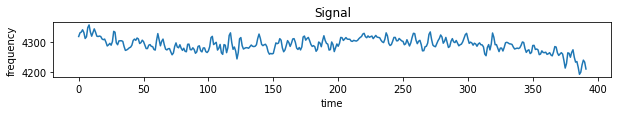

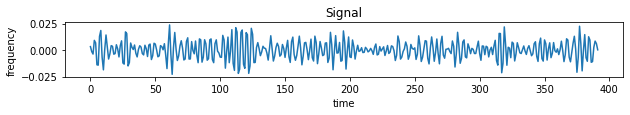

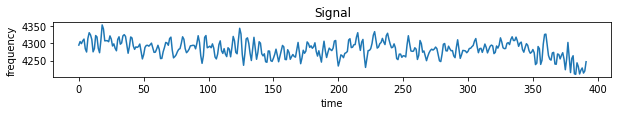

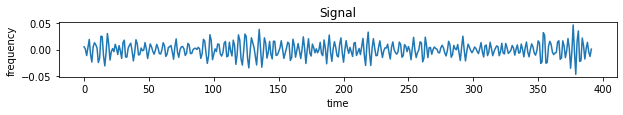

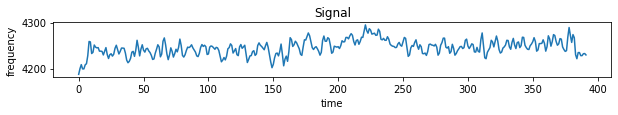

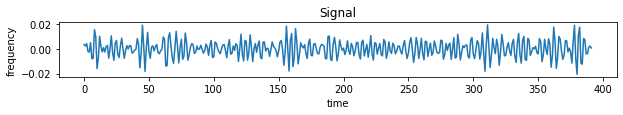

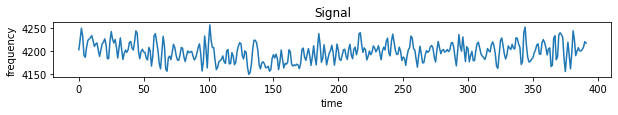

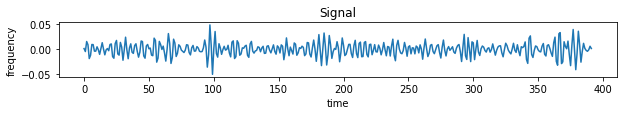

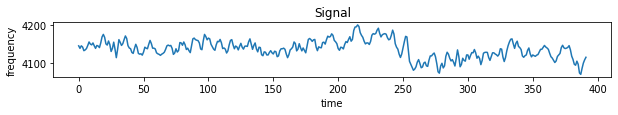

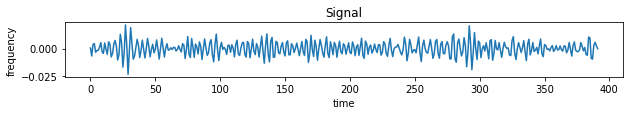

In [21]:
#check sample data (5 signals): before and after filtering
x_sample,y_sample = prepare_data(df_sample,5,unit_test=True) 

### Create X, y

In [22]:
#get final data for model : X, y
X,y = prepare_data(df_main,5)

X= np.array(X)   #convert X to numpy array

le = LabelEncoder()
y = le.fit_transform(y)                                 #for ML models
yy = tf.keras.utils.to_categorical(le.fit_transform(y)) #for cateorical problems

# Resampling X, y

In [23]:
orig_shape = X.shape

#take backup
X_orig=X.copy()
y_orig=y.copy()

print(orig_shape)
X = np.reshape(X, (X.shape[0],-1))
X.shape #after reshaping

(14012, 5, 392)


(14012, 1960)

In [24]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import collections, numpy

def print_counter(y_data):
  counter = Counter(y)
  for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
  #plot the distribution of classes
  plt.bar(counter.keys(), counter.values())
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Class=0, n=7735 (55.203%)
Class=2, n=638 (4.553%)
Class=5, n=539 (3.847%)
Class=7, n=1009 (7.201%)
Class=3, n=1713 (12.225%)
Class=8, n=1179 (8.414%)
Class=6, n=581 (4.146%)
Class=4, n=149 (1.063%)
Class=1, n=469 (3.347%)


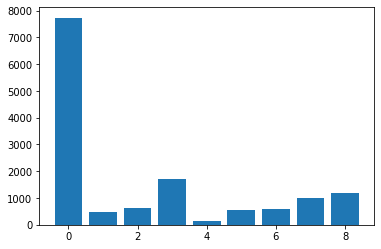

In [25]:
print_counter(y) #original y distribution

In [26]:

count_class=collections.Counter(y)
print(count_class) #occurances of all classes
count_class[0] #number of occurances of class 0

Counter({0: 7735, 3: 1713, 8: 1179, 7: 1009, 2: 638, 6: 581, 5: 539, 1: 469, 4: 149})


7735

In [27]:
int(count_class[0]*25/100)  #retain 25% of data from 0 with 0 class

1933

### Undersampling majority classes

Class=0, n=1933 (23.544%)
Class=1, n=469 (5.713%)
Class=2, n=638 (7.771%)
Class=3, n=1713 (20.865%)
Class=4, n=149 (1.815%)
Class=5, n=539 (6.565%)
Class=6, n=581 (7.077%)
Class=7, n=1009 (12.290%)
Class=8, n=1179 (14.361%)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


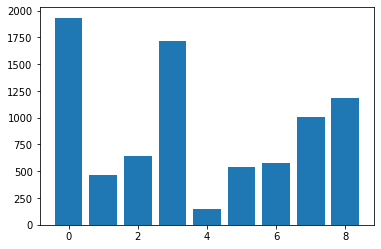

In [28]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler({0:int(count_class[0]*25/100)},random_state=0)
rus.fit(X, y)
X, y = rus.fit_resample(X, y)


print_counter(y)

### Oversampling minority classes

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class=0, n=1933 (11.111%)
Class=1, n=1933 (11.111%)
Class=2, n=1933 (11.111%)
Class=3, n=1933 (11.111%)
Class=4, n=1933 (11.111%)
Class=5, n=1933 (11.111%)
Class=6, n=1933 (11.111%)
Class=7, n=1933 (11.111%)
Class=8, n=1933 (11.111%)


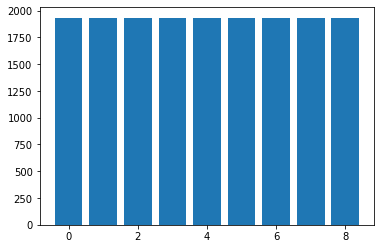

In [29]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
ros.fit(X, y)
X, y = ros.fit_resample(X, y)

print_counter(y)

In [30]:
new_shape=(X.shape[0],orig_shape[1],orig_shape[2])
new_shape

(17397, 5, 392)

In [31]:
X = np.reshape(X, new_shape)
print(X.shape)

(17397, 5, 392)


# After sampling : X, y

In [32]:
X=X 
y=y
yy = tf.keras.utils.to_categorical(le.fit_transform(y)) #for cateorical problems/DNN

In [33]:
X.shape, y.shape, yy.shape

((17397, 5, 392), (17397,), (17397, 9))

In [34]:
type(X), type(y), type(yy)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [35]:
X[1][4][2]   #verify data

0.02816516229443882

In [36]:
y[:5]

array([0, 0, 0, 0, 0])

In [37]:
yy[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [38]:
#shuffle data

idx = np.random.permutation(len(X))
X_nn = X[idx]
y_nn = yy[idx]                  #for simple caegorical problem
y_ml = y[idx]                   #for ML models

In [39]:
X_nn.shape, y_nn.shape, y_ml.shape

((17397, 5, 392), (17397, 9), (17397,))

In [40]:
num_labels = len(np.unique(y_ml))
num_labels

9

In [41]:
#plot accuracies
def plot_accuracy(history, plot_type="accuracy"):
  if plot_type=="categorical_accuracy":
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
  else:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
  
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  print("\n")

#plot loss graph
def plot_loss(history):
  plt.plot(history.history['loss']) 
  plt.plot(history.history['val_loss']) 
  plt.title('Model loss') 
  plt.ylabel('Loss') 
  plt.xlabel('Epoch') 
  plt.legend(['Train', 'Test'], loc='upper left') 
  plt.show()
  print("\n")

# CNN

In [42]:
#y_nn for categorical

X_train, X_test, y_train, y_test = train_test_split(X_nn,y_nn, test_size=0.3, random_state = 2021,shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12177, 5, 392), (5220, 5, 392), (12177, 9), (5220, 9))

In [43]:
from keras.layers import Input,Conv1D, Dense, GlobalAveragePooling1D, ReLU, Dropout, BatchNormalization


In [44]:
def make_model(input_shape):

    input_layer = Input(input_shape)

    conv1 = Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 =BatchNormalization()(conv1)
    conv1 =Dropout(0.3)(conv1)  #extra
    conv1 =ReLU()(conv1)

    conv2 =Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 =Dropout(0.3)(conv2)  #extra
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.3)(conv3)  #extra
    conv3 =ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    output_layer = Dense(num_labels, activation="softmax")(gap)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return model

In [45]:

model = make_model(input_shape=X_train.shape[1:])
#keras.utils.plot_model(model, show_shapes=True)   #visual representation of summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 392)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 5, 64)             75328     
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 64)             256       
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
re_lu (ReLU)                 (None, 5, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 64)             256   

In [46]:
epochs = 500
batch_size = 32

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)  #early stopping #overfitting

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.01
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), 
                    verbose=1,callbacks=callbacks)  #early stopping # overfittin

Epoch 1/500
381/381 [==============================] - 4s 7ms/step - loss: 2.2508 - categorical_accuracy: 0.1151 - val_loss: 2.1963 - val_categorical_accuracy: 0.1280
Epoch 2/500
381/381 [==============================] - 2s 6ms/step - loss: 2.1954 - categorical_accuracy: 0.1447 - val_loss: 2.1520 - val_categorical_accuracy: 0.1684
Epoch 3/500
381/381 [==============================] - 2s 6ms/step - loss: 2.1423 - categorical_accuracy: 0.1796 - val_loss: 2.1029 - val_categorical_accuracy: 0.2059
Epoch 4/500
381/381 [==============================] - 2s 6ms/step - loss: 2.0625 - categorical_accuracy: 0.2179 - val_loss: 2.0311 - val_categorical_accuracy: 0.2385
Epoch 5/500
381/381 [==============================] - 2s 6ms/step - loss: 1.9754 - categorical_accuracy: 0.2583 - val_loss: 1.9726 - val_categorical_accuracy: 0.2508
Epoch 6/500
381/381 [==============================] - 2s 6ms/step - loss: 1.9021 - categorical_accuracy: 0.2882 - val_loss: 1.9565 - val_categorical_accuracy: 0.272

In [47]:
#model = keras.models.load_model("best_model.h5")

train_loss, train_acc = model.evaluate(X_train, y_train)

print("Train accuracy", train_acc)
print("Train loss", train_loss)

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

381/381 [==============================] - 1s 2ms/step - loss: 0.3133 - categorical_accuracy: 0.9073
Train accuracy 0.9072842001914978
Train loss 0.3133256435394287
164/164 [==============================] - 0s 2ms/step - loss: 0.9980 - categorical_accuracy: 0.6990
Test accuracy 0.6990421414375305
Test loss 0.9979597926139832


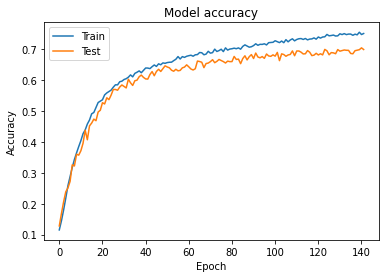

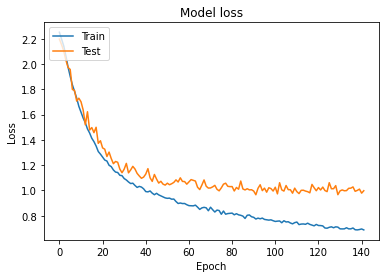

In [48]:
plot_accuracy(history,model.metrics_names[1])
print("\n")
plot_loss(history)

# LSTM

In [49]:
#y_nn for categorical

X_train, X_test, y_train, y_test = train_test_split(X_nn,y_nn, test_size=0.3, random_state = 2021,shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12177, 5, 392), (5220, 5, 392), (12177, 9), (5220, 9))

In [50]:
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout

In [51]:
def make_model_LSTM(input_shape):
    model = Sequential()

    model.add(LSTM(500, input_shape=X_train.shape[1:]))

    model.add(Dropout(0.2))

    #model.add(Dense(256, activation='relu'))

    model.add(Dense(128, activation='relu'))

    model.add(Dense(num_labels, activation='softmax'))

    return model


model = make_model_LSTM(X_train.shape[1:])
#keras.utils.plot_model(model, show_shapes=True)   #visual representation of summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500)               1786000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               64128     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1161      
Total params: 1,851,289
Trainable params: 1,851,289
Non-trainable params: 0
_________________________________________________________________


In [52]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)  #early stopping #overfitting

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.01
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [53]:
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), 
                    verbose=1,callbacks=callbacks)

Epoch 1/500
381/381 [==============================] - 20s 50ms/step - loss: 2.1950 - accuracy: 0.1233 - val_loss: 2.1777 - val_accuracy: 0.1307
Epoch 2/500
381/381 [==============================] - 18s 48ms/step - loss: 2.1543 - accuracy: 0.1520 - val_loss: 2.1455 - val_accuracy: 0.1565
Epoch 3/500
381/381 [==============================] - 18s 48ms/step - loss: 2.1083 - accuracy: 0.1800 - val_loss: 2.1202 - val_accuracy: 0.1672
Epoch 4/500
381/381 [==============================] - 18s 48ms/step - loss: 2.0655 - accuracy: 0.2017 - val_loss: 2.0872 - val_accuracy: 0.1941
Epoch 5/500
381/381 [==============================] - 18s 48ms/step - loss: 2.0224 - accuracy: 0.2218 - val_loss: 2.0459 - val_accuracy: 0.2209
Epoch 6/500
381/381 [==============================] - 18s 48ms/step - loss: 1.9749 - accuracy: 0.2478 - val_loss: 2.0038 - val_accuracy: 0.2441
Epoch 7/500
381/381 [==============================] - 18s 48ms/step - loss: 1.9012 - accuracy: 0.2823 - val_loss: 1.9663 - val_ac

In [54]:
#model = keras.models.load_model("best_model.h5")

train_loss, train_acc = model.evaluate(X_train, y_train)

print("Train accuracy", train_acc)
print("Train loss", train_loss)

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

381/381 [==============================] - 5s 14ms/step - loss: 0.0407 - accuracy: 0.9873
Train accuracy 0.9872710704803467
Train loss 0.04071008414030075
164/164 [==============================] - 2s 14ms/step - loss: 3.0055 - accuracy: 0.7157
Test accuracy 0.7157087922096252
Test loss 3.0054593086242676


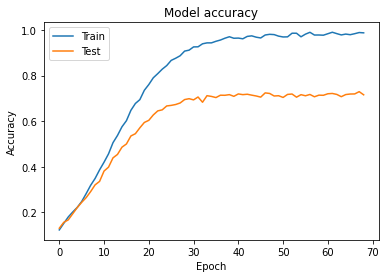

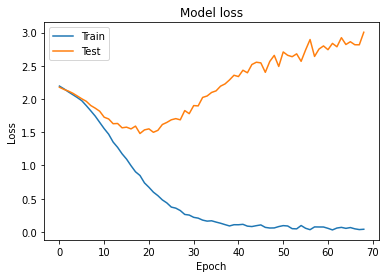

In [55]:
plot_accuracy(history,model.metrics_names[1])
print("\n")
plot_loss(history)